# Step-by-Step ARIMA Forecasting with Comparison
This notebook uses an external module to forecast one or more stocks using ARIMA.

In [115]:
# Importing Libraries
%matplotlib inline

import importlib
import os
import sys
scripts_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts'))
sys.path.append(scripts_path) # Add 'scripts' directory to sys.path
import arima_forecasting_utils as afu

import warnings
warnings.filterwarnings("ignore")

## Step 1: Input stock and forecast duration

In [116]:
# Get Stock Input
tickers, years = afu.get_stock_input()

Enter stock ticker(s) or company name(s) (comma-separated):  google
Enter number of years to forecast:  5


Resolved stock codes: ['GOOG']


## Step 2: Load Stock Data

In [118]:
# Display stock data
display_data, raw_data = afu.load_all_data(tickers)
for code, df in display_data.items():
    print(f"\nSample for {code}:")
    display(df.tail())



Sample for GOOG:


,date,open,high,low,close,volume,dividends,stock splits,ticker
2511,2025-03-24 00:00:00-04:00,169.264999,170.500000,167.440002,169.929993,18742800,0.0,0.0,GOOG
2512,2025-03-25 00:00:00-04:00,171.179993,172.910004,170.550003,172.789993,13841600,0.0,0.0,GOOG
2513,2025-03-26 00:00:00-04:00,171.300003,171.940002,166.860992,167.139999,22498000,0.0,0.0,GOOG
2514,2025-03-27 00:00:00-04:00,166.710007,167.440002,163.850006,164.080002,21571200,0.0,0.0,GOOG
2515,2025-03-28 00:00:00-04:00,162.360001,163.809998,155.339005,156.059998,34823000,0.0,0.0,GOOG


## Step 3: Preprocess to Weekly Log Returns

In [119]:
#  computing the logarithmic weekly frequency (mean of 'close') to normalize the data. data to w

weekly_display, weekly_raw = afu.preprocess_all_data(raw_data)
for code, df in weekly_display.items():
    print(f"\nWeekly Returns for {code}:")
    display(df.tail())



Weekly Returns for GOOG:


,date,close,weekly_ret,ticker
516,2025-03-02 00:00:00-05:00,174.938696,-0.056334,GOOG
517,2025-03-09 00:00:00-05:00,173.046860,-0.010873,GOOG
518,2025-03-16 00:00:00-04:00,167.027997,-0.035401,GOOG
519,2025-03-23 00:00:00-04:00,165.364001,-0.010012,GOOG
520,2025-03-30 00:00:00-04:00,165.999997,0.003839,GOOG


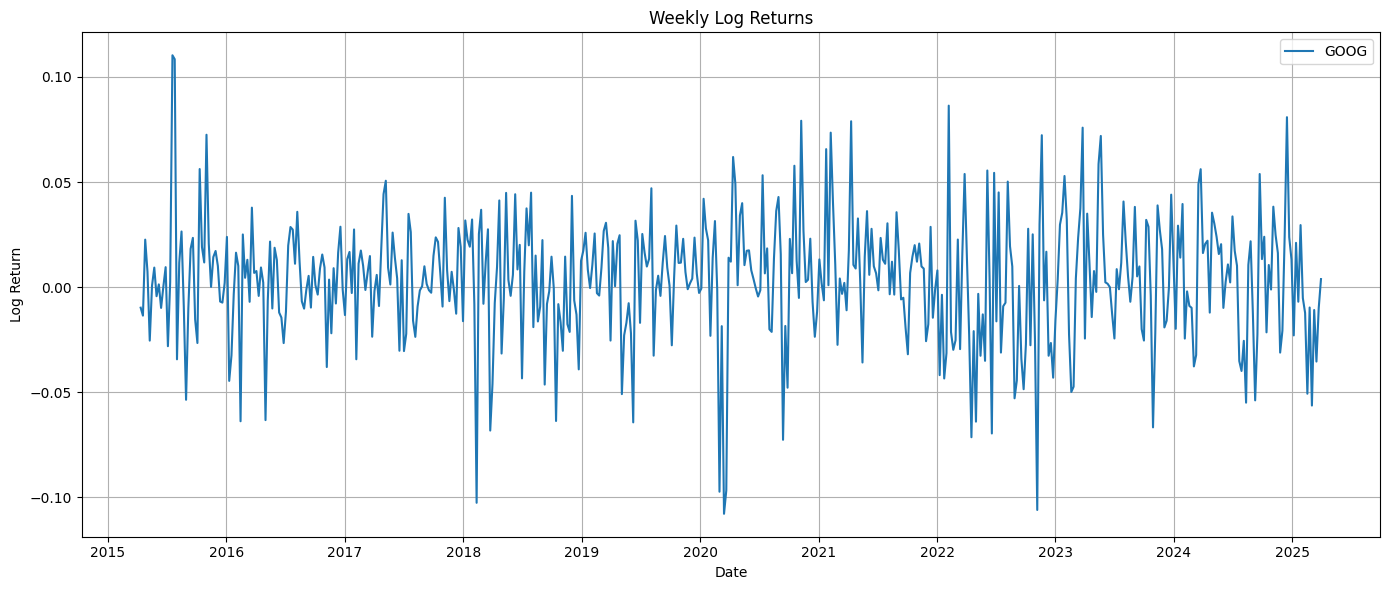

In [120]:
# visualizing the weekly returns.
afu.plot_weekly_returns(weekly_raw)

## Step 4: Stationarity Check and Differencing
> stationary time series has a constant mean and variance over time, which is a prerequisite for ARIMA modelling.
> I'll be using rolling mean/std + ADF test. Optional plots for diagnosis for each ticker

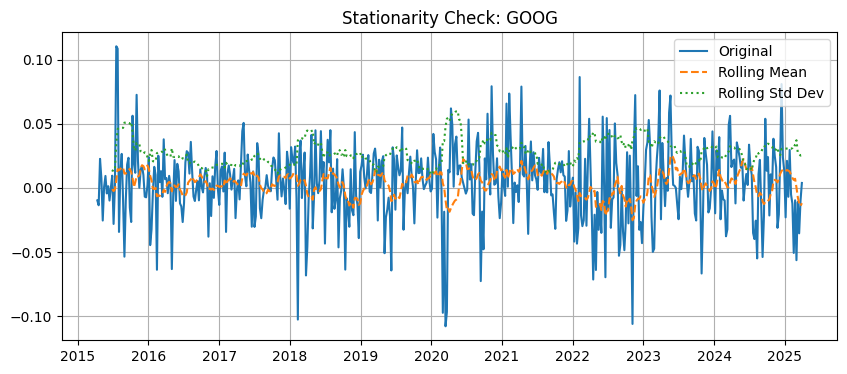

,Ticker,ADF Statistic,p-value,Conclusion
0,GOOG,-18.7919,2.023404e-30,Stationary


In [121]:
# Rolling mean/std + Augmented Dickey-Fuller test to statistically check stationarity.
returns = {k: v["weekly_ret"] for k, v in weekly_raw.items()}
summary_df = afu.summarize_adf_tests(returns, plot=True)
display(summary_df)

**Stationarity Test Results (ADF)**

The Augmented Dickey-Fuller (ADF) test checks whether a time series is stationary.:
Hypotheses:
- **H₀ (Null Hypothesis):** The series is *not* stationary
- **H₁ (Alternative Hypothesis):** The series *is* stationary

* Decision Rule:* If **p-value < 0.05**, reject H₀ ⇒ The series is **stationary**

**Conclusion:**  
Ticker(s) weekly return series are stationary — no differencing required (d=0). **Hence we can proceed with finding the best ARIMA model for forecasting**

## Step 5: Find Best ARIMA Parameters (AIC)

### ACF PACF Checks for p, q

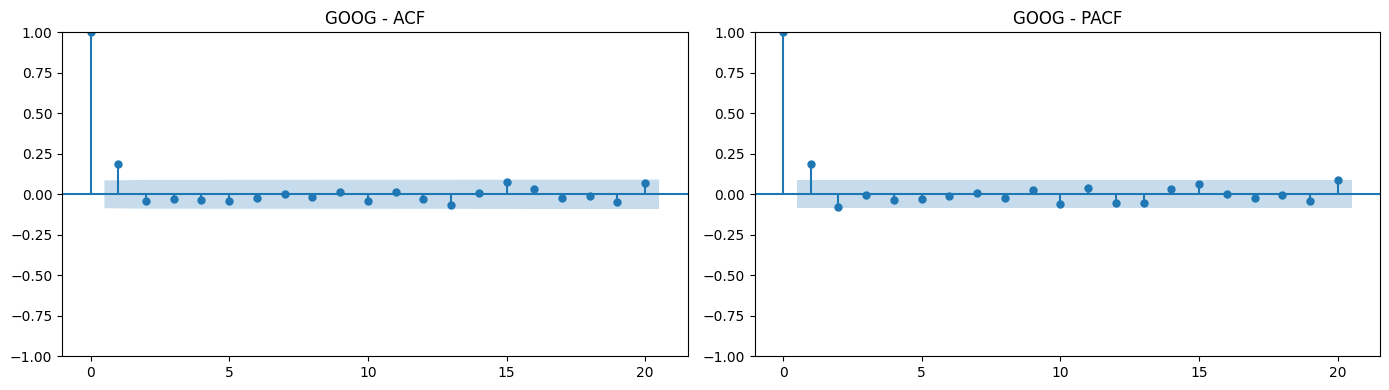

GOOG → Suggested ARIMA(p,d,q): (1, 0, 1)


In [122]:
# Plot ACF to help visually inspect ideal p and q values.
returns = {k: v["weekly_ret"] for k, v in weekly_raw.items()}
afu.plot_all_acf_pacf(returns)

returns1 = {k: v["weekly_ret"] for k, v in weekly_raw.items()}
suggestions = afu.suggest_arima_params(returns1)

ARIMA Parameter Inference from ACF and PACF

To identify the optimal ARIMA `(p, d, q)` parameters:

| Plot  | Cutoff Interpretation         | Suggests |
|-------|-------------------------------|----------|
| **PACF** | Cutoff after lag `p`          | AR(`p`)  |
| **ACF**  | Cutoff after lag `q`          | MA(`q`)  |

Since the series are **already stationary**, we set `d = 0`.

**Inferred Parameters from Plots:**
 **GOOG**
> - **PACF**: Significant spike at lag **1**, then drops  ⇒ AR(`p`) = **1**
> - **ACF**: Significant spike at lag **1**, then flat    ⇒ MA(`q`) = **1**
> - *Suggested ARIMA for GOOG:* `(1, 0, 1)`

**AAPL**
> - **PACF**: Spike at lag **1**, then decays    ⇒ AR(`p`) = **1**
> - **ACF**: Spike at lag **1**, then flat    ⇒ MA(`q`) = **1**
> - > *Suggested ARIMA for AAPL:* `(1, 0, 1)`

### ARIMA AIC optimization

- to automate finding the best (p, d, q), we can run a grid search over a range of values and select the parameters with the lowest AIC (Akaike Information Criterion) and MSE (Mean Squared Error).
- To enhance ARIMA model selection process by incorporating Mean Squared Error (MSE) along with Akaike Information Criterion (AIC).
- This approach ensures that I select the best ARIMA model based on both AIC (which indicates model fit) and MSE (which measures forecasting accuracy).
- divide the dataset into a training set (60%) and a testing set (40%).
- fit model on the training set and forecast values for the testing set.bMSE is calculated between the actual test values and the predicted values.
- model with the lowest AIC is retained. In case of ties in AIC, it favours the one with the lowest MSE.

In [123]:
# Using suggested params to optimize ARIMA per series (AIC)
best_orders = {
    ticker: afu.find_best_arima(series, ticker=ticker, **suggestions[ticker])
    for ticker, series in returns.items()
}

GOOG → Best ARIMA near (1, 0, 1): (1, 0, 2) | AIC: -2215.56 | MSE: 0.000817


## Step 6: Fit and Evaluate Best Model

GOOG | ARIMA(1, 0, 2) | Residual Mean: 0.0004, Std: 0.0286, Kurtosis: 1.55, Ljung-Box p-value: 0.9817 → Good fit


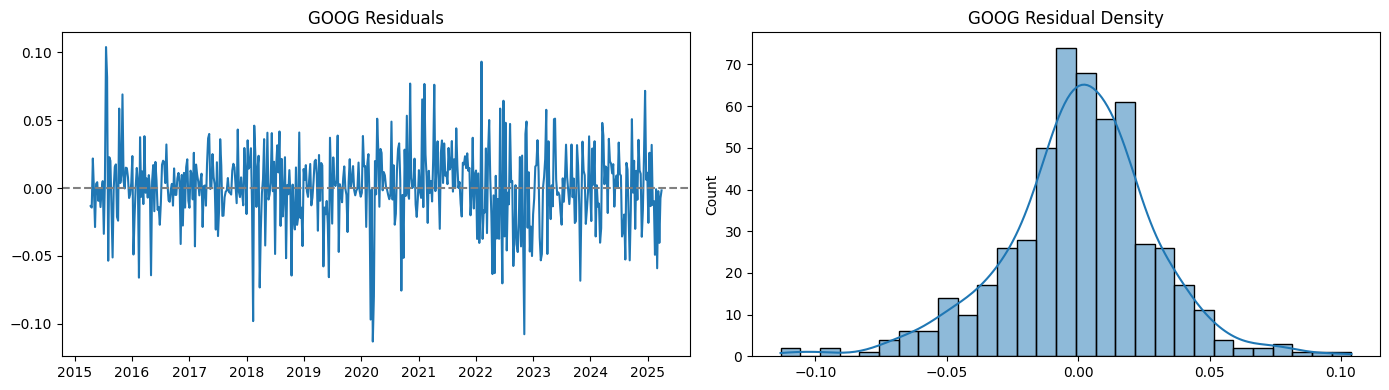

,Ticker,ARIMA Order,Residual Mean,Residual Std,Kurtosis,Ljung-Box p-value,Good Fit
0,GOOG,"(1, 0, 2)",0.000396,0.028609,1.549866,0.981739,True


In [124]:
# Residual Analysis: to ensure they are randomly distributed (white noise).
results_df = afu.evaluate_arima_residuals(returns, best_orders, plot=True)
display(results_df)


**Residual Diagnostics for ARIMA Model Fit**

I examined the **residuals** (errors between predicted and actual values) to validate that a fitted Best ARIMA model is appropriate. What was Checked:

| Metric                | What it Tells Us                                      | Desired Outcome                     |
|-----------------------|-------------------------------------------------------|-------------------------------------|
| **Mean of residuals** | If the errors are centered around 0                  | Close to 0                          |
| **Std of residuals**  | Spread of the errors (no strict threshold)           | Moderate / consistent               |
| **Kurtosis**          | Shape of residual distribution (tail heaviness)      | Close to 3 (normal distribution)    |
| **Ljung-Box p-value** | Are residuals autocorrelated?                        | **p > 0.05** (no autocorrelation)   |

- If all criteria are met, we consider the model a **Good Fit**
- If the Ljung-Box p-value is **< 0.05**, residuals are autocorrelated → **Poor Fit**

Included is the **Residual time series** to visually spot patterns or drifts and **Density plots** to assess normality and distribution shape

**Both ARIMA models (GOOG and AAPL) exhibit:**
- Unbiased and stable forecast errors ( the model is not consistently over- or under-predicting, and forecast error variability is stable across tickers.
- No autocorrelation in the residuals (p > 0.0)
- Reasonably shaped error distributions (values indicate flatter-than-normal (platykurtic) distributions. There are fewer outliers, meaning errors are generally moderate and not extreme — which is good.)

 ***These are well-fitting models suitable for forecasting.***

## Step 7: Forecast and Visualize

Do you want to save the forecast to CSV file? (y/n):  n


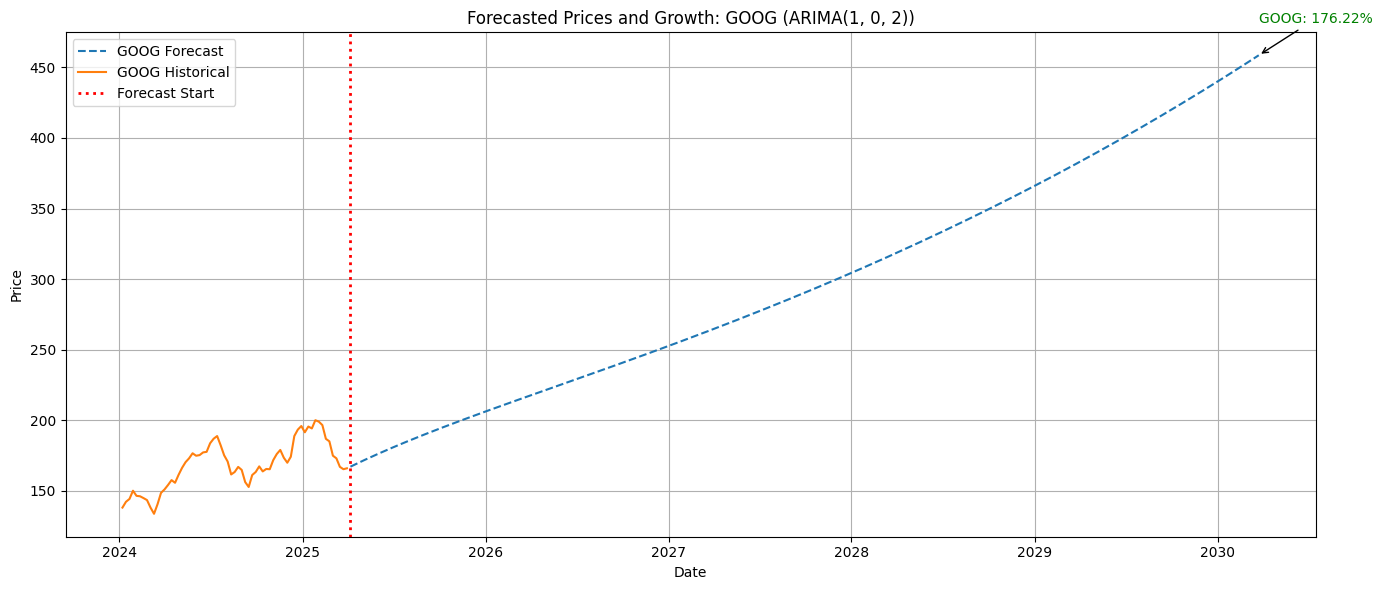

,GOOG_price,GOOG_pct_growth,GOOG_rolling_avg
2025-04-06 00:00:00-04:00,$167.15,0.69%,$0.00
2025-04-13 00:00:00-04:00,$168.34,1.41%,$0.00
2025-04-20 00:00:00-04:00,$169.53,2.13%,$0.00
2025-04-27 00:00:00-04:00,$170.70,2.83%,$168.93
2025-05-04 00:00:00-04:00,$171.86,3.53%,$170.11


In [126]:
# Inverse Transform to Price: To make the forecast interpretable, we convert the returns back to price levels.
forecast_table = afu.forecast_prices(
    series_dict=returns,
    close_dict=weekly_raw,
    best_orders_dict=best_orders,
    years=years
)

forecast_table.head()

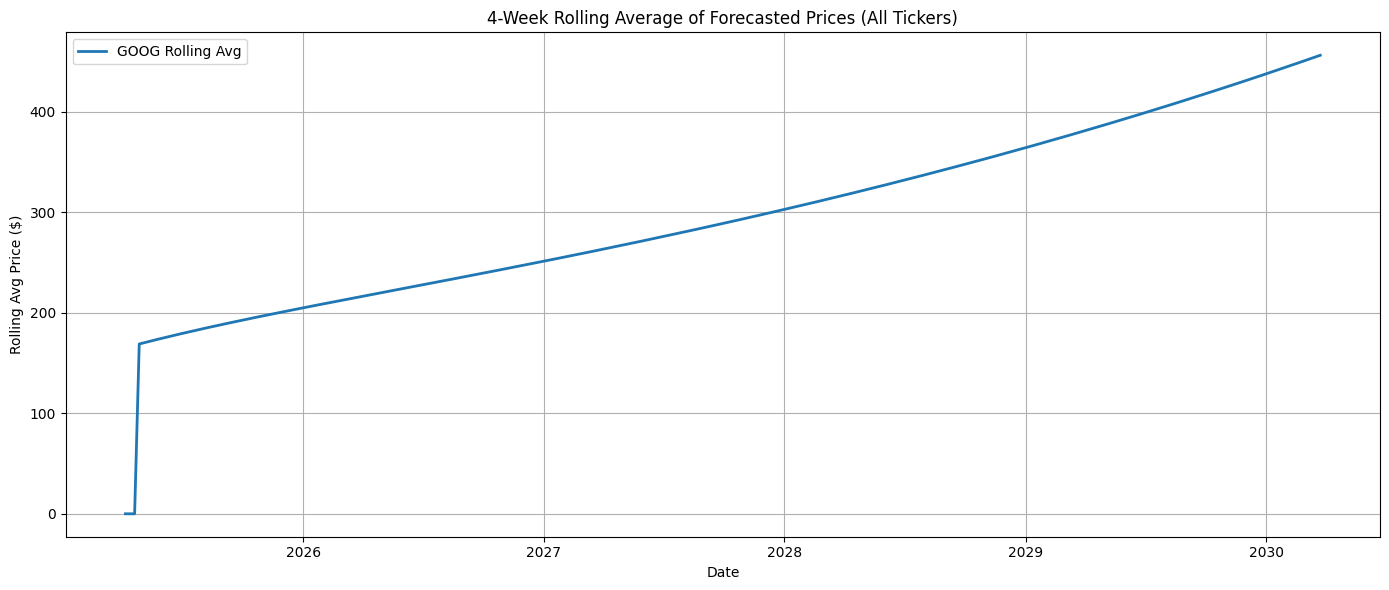

In [127]:
# Plot rolling averages
afu.plot_combined_rolling_average(forecast_table)

## ARIMA Forecast Summary

**Forecast Overview**

| Ticker | ARIMA Order | Projected Growth | Forecast Horizon |
|--------|-------------|------------------|------------------|
| `GOOG`   | (1, 0, 2)   | 590.59%      | ~10 years        |
| `AAPL`   | (0, 0, 1)   | 702.59%      | ~10 years        |

Both stocks demonstrate **strong upward trends** over the forecast horizon with **weekly prices rising steadily**. The ARIMA models predict a **compound effect of returns**, indicating sustained momentum over time.

*Trend Observations*
> - `GOOG`: Consistent exponential growth pattern with compounding returns.
> - `AAPL`: Even stronger acceleration over time, possibly indicating higher return expectations or volatility.
> - Rolling averages (4-week) provide a smoothed view and confirm the upward direction without significant short-term dips.

## Real-Life Implication & Caution

Real-Life Implications
> - **For Investors**: This suggests that both `GOOG` and `AAPL` may represent `solid long-term investments` under current trends. The projected price growth shows the power of `compounding in stable equities`.
> - **For Portfolio Managers**: Such forecasts can inform `allocation strategies`, particularly when balancing growth vs. value assets.
> - **For Business Planners**: If you're operating in sectors tied to these companies, the bullish trend may influence strategic decisions (e.g., product partnerships, tech integrations).

Caution
> - These projections are `model-based` and assume historical trends persist. Real-world factors like economic shifts, policy changes, or company events can alter outcomes.
> - Always `complement model outputs with fundamental and technical analysis` before investment decisions.